In [1]:
import xarray as xr
import numpy as np
from isca_tools import cesm
from isca_tools.utils import area_weighting, lat_lon_rolling
from isca_tools.utils import print_ds_var_list
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import matplotlib.patches as patches
from tqdm import tqdm

### Load in Datasets
This will load in every year of daily data saved for the output directory.

In [16]:
# exp_name = 'e.e20.E1850TEST.f09_g17.test'
# exp_name = 'e.e20.ETEST.f19_g17.test_daily_output'
exp_name = 'e.e20.E1850TEST.f09_g17.daily_output'
# var_keep = ['TS', 'FSNTOA', 'FLNT', 'gw', 'T']
# ds_monthly = cesm.load_dataset(exp_name, archive_dir=cesm.local_archive_dir, months_keep=[1]).load()
ds = cesm.load_dataset(exp_name, archive_dir=cesm.local_archive_dir, hist_file=1)
ds_lnd = cesm.load_dataset(exp_name, archive_dir=cesm.local_archive_dir, hist_file=1, comp='lnd', year_first=-1, year_last=-1)

In [17]:
p_ft_approx = 500
p_surf_approx = 1000
ind_ft = int(np.argmin(np.abs(ds.T.lev-p_ft_approx).to_numpy()))
ind_surf = int(np.argmin(np.abs(ds.T.lev-p_surf_approx).to_numpy()))
p_ft = float(ds.T.lev[ind_ft])*100
p_surf = float(ds.T.lev[ind_surf])*100

## Each Latitude Separately 
Here, I consider each latitude individually, and create a quantile dataset for all ocean points and all land points at that latitude.

### Find land coordinates
Say land is where land fraction > 0.5

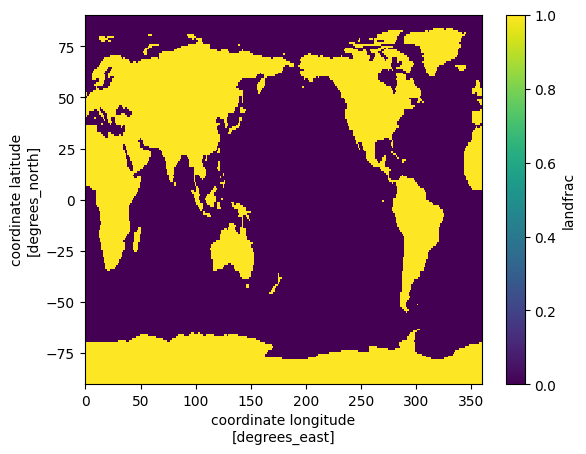

In [18]:
landfrac_thresh = 0.5
is_land = ds_lnd.landfrac.isel(time=0, drop=True)>landfrac_thresh
is_land.plot();

### Load in dataset for all latitudes
Next I load in the dataset for all latitudes. It is a lot quicker to load all latitudes at once than each latitude individually. But in the future, for memory purposes it may be more beneficial to load in each latitude separately.

In [19]:
%%time
# Load in datasets - next cell is a lot quicker if load in all latitudes at the same time
var_atm = ['T', 'Q', 'Z3']
ds_base = ds.isel(lev=[ind_surf, ind_ft])[var_atm].load()
soil_liq_base = ds_lnd.SOILLIQ.sum(dim='levsoi').load()

CPU times: user 7.31 s, sys: 5.67 s, total: 13 s
Wall time: 16.3 s


### Get data for convective theory
Below I record the quantile of various variables required for my analysis of the convective limit to near-surface temperature.

In [20]:
n_lat = ds.lat.size
quant_use = [90, 95, 99]
quant_range = 0.5       # find quantile by looking for all values in quantile range between quant_use-quant_range to quant_use+quant_range
n_quant = len(quant_use)
output_info = {var: np.zeros((2, n_lat, n_quant)) for var in  ['temp', 'temp_ft', 'sphum', 'z', 'z_ft', 'mse', 'mse_sat_ft', 'mse_lapse', 
                                                               'soil_liq']}
for var in ['temp', 'temp_ft', 'sphum', 'z', 'z_ft', 'mse', 'mse_sat_ft', 'mse_lapse', 'soil_liq']:
    output_info[var+'_std'] = np.zeros((2, n_lat, n_quant))
output_info['lon_most_common'] = np.zeros((2, n_lat, n_quant))
output_info['lon_most_common_freq'] = np.zeros((2, n_lat, n_quant), dtype=int)
output_info['n_grid_points'] = np.zeros((2, n_lat), dtype=int)         # number of grid points used at each location
output_info['surface'] = ['land', 'ocean']

# Record approx number of days used in quantile calculation. If quant_range=0.5 and 1 year used, this is just 0.01*365=3.65
output_info['n_days_quant'] = get_quant_ind(np.arange(ds_base.time.size*n_lat), quant_use[0], quant_range, quant_range).size/n_lat
with tqdm(total=2*n_quant*n_lat, position=0, leave=True) as pbar:
    for k, surf in enumerate(output_info['surface']):
        if surf == 'land':
            is_surf = is_land
        else:
            is_surf = ~is_land
        for i in range(n_lat):
            if is_surf.isel(lat=i).sum() == 0:
                # If surface not at this latitude, record no data
                pbar.update(n_quant)
                continue
            ds_use = ds_base.isel(lat=i).sel(lon=is_surf.isel(lat=i))[var_atm]
            ds_use = ds_use.stack(lon_time=("lon", "time"), create_index=False).chunk(dict(lon_time=-1))
            if surf == 'land':
                soil_liq_use = soil_liq_base.isel(lat=i).sel(lon=is_surf.isel(lat=i))
                soil_liq_use = soil_liq_use.stack(lon_time=("lon", "time"), 
                                                  create_index=False).chunk(dict(lon_time=-1))
            output_info['n_grid_points'][k, i] = ds_use.lon.size
            for j in range(n_quant):
                # get indices corresponding to given near-surface temp quantile
                use_ind = get_quant_ind(ds_use.T.isel(lev=0), quant_use[j], quant_range, quant_range)    
                n_days_use = len(use_ind)
                var_use = {}
                var_use['temp'] = ds_use.T.isel(lev=0, lon_time=use_ind)
                var_use['temp_ft'] = ds_use.T.isel(lev=1, lon_time=use_ind)
                var_use['sphum'] = ds_use.Q.isel(lev=0, lon_time=use_ind)
                var_use['z'] = ds_use.Z3.isel(lev=0, lon_time=use_ind)
                var_use['z_ft'] = ds_use.Z3.isel(lev=1, lon_time=use_ind)
                var_use['mse'] = moist_static_energy(ds_use.T.isel(lev=0), ds_use.Q.isel(lev=0), 
                                                     ds_use.Z3.isel(lev=0)).isel(lon_time=use_ind)
                var_use['mse_sat_ft'] = moist_static_energy(ds_use.T.isel(lev=1), sphum_sat(ds_use.T.isel(lev=1), p_ft), 
                                                            ds_use.Z3.isel(lev=1)).isel(lon_time=use_ind)
                var_use['mse_lapse'] = var_use['mse'] - var_use['mse_sat_ft']
                if surf == 'land':
                    var_use['soil_liq'] = soil_liq_use.isel(lon_time=use_ind)
                for key in var_use:
                    output_info[key][k, i, j] = var_use[key].mean()
                    output_info[key+'_std'][k, i, j] = var_use[key].std()
                lon_use = np.unique(ds_use.lon[use_ind], return_counts=True)
                
                # Record most common specific coordinate within grid to see if most of days are at a given location
                output_info['lon_most_common'][k, i, j] = lon_use[0][lon_use[1].argmax()]
                output_info['lon_most_common_freq'][k, i, j] = lon_use[1][lon_use[1].argmax()]
                pbar.update(1)

100%|██████████| 1152/1152 [01:04<00:00, 17.74it/s]


### Add basic details to output
Below I add some basic information of the simulation and details of the quantile analysis to the output dictionary.

In [21]:
# Add basic info of the dataset and averaging details used
output_info['exp_name'] = exp_name
output_info['date_start'] = ds.time.to_numpy()[0].strftime()
output_info['date_end'] = ds.time.to_numpy()[-1].strftime()
output_info['lat'] = ds.lat.to_numpy()
output_info['lon'] = ds.lon.to_numpy()
output_info['pressure_surf'] = p_surf
output_info['pressure_ft'] = p_ft
output_info['quant'] = quant_use
output_info['quant_range'] = quant_range
output_info['landfrac_thresh'] = landfrac_thresh

### Save output data as npz file

In [27]:
# Save file
# np.savez_compressed(f'/Users/joshduffield/Desktop/{exp_name}.lat_quant_info.npz', **output_info)
# a = np.load('/Users/joshduffield/Desktop/hi_compress.npz')